In [1]:
import pandas as pd
import re, string, unicodedata
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb

In [2]:
#Loading the data
df_data = pd.read_csv('C:\Sujata\CompScience\Winter 2021\Data Mining\Project Final\mbti_1\mbti_1.csv')

# Removed |||
df_data.posts = df_data.posts.replace(r'[|||]', r' ', regex=True)
df_data.head()

c:\users\madhu\appdata\local\programs\python\python37\lib\site-packages\pandas\core\dtypes\inference.py:178: FutureWarning: Possible set union at position 2
  re.compile(obj)


,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw h...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired. That's another silly misconce...


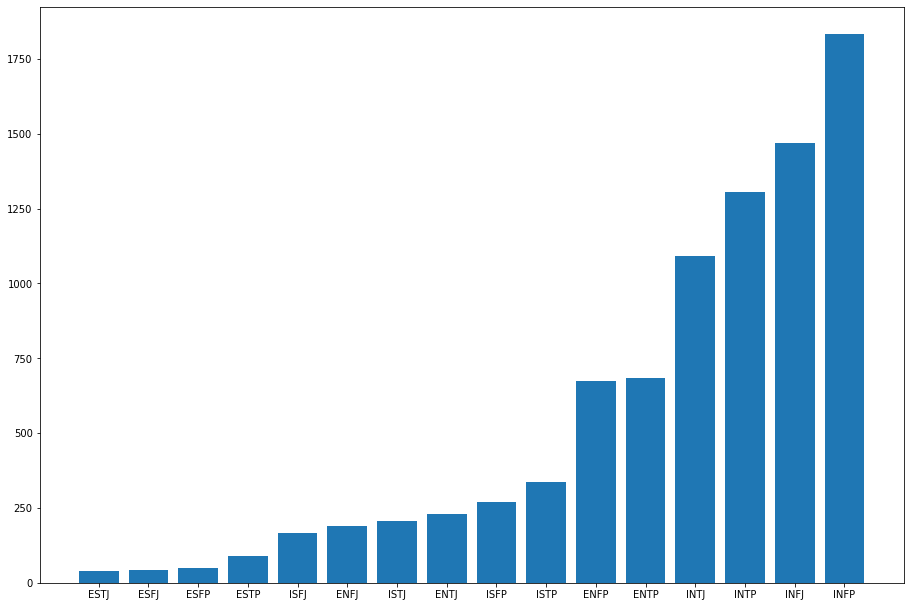

In [3]:
#Data is not balanced
def count_class(DataFrame,count = False ,plot = False):
    # considering 1st Column is for classes 
    Classes = list(df_data[df_data.columns[0]].unique())
    #print(Classes)
    if plot or count:
        count_type = df_data.groupby('type').count()
    #if count : print(count_type)
    if plot:
        fig = plt.figure()
        ax = fig.add_axes([0,0,2,2])
        count_type_temp = count_type.sort_values('posts')
        ax.bar(count_type_temp.index,count_type_temp['posts'])
        plt.show()
    return Classes

classes = count_class(df_data,True,True)

In [4]:
#Diving the 16 MBTI type to only 4
df_data['is_E'] = df_data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_data['is_S'] = df_data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_data['is_T'] = df_data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_data['is_J'] = df_data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df_data

,type,posts,is_E,is_S,is_T,is_J
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw h...,0,0,0,1
1,ENTP,I'm finding the lack of me in these posts very...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,0
8672,INTP,'So many questions when i do these things. I ...,0,0,1,0
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,0


In [5]:
#dropping the type column
df_data = df_data.drop(['type'], axis=1)
df_data

,posts,is_E,is_S,is_T,is_J
0,http://www.youtube.com/watch?v=qsXHcwe3krw h...,0,0,0,1
1,I'm finding the lack of me in these posts very...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,'So...if this thread already exists someplace ...,1,0,0,0
8672,'So many questions when i do these things. I ...,0,0,1,0
8673,'I am very conflicted right now when it comes ...,0,0,0,0


In [6]:
#Separating the data according to I/E , N/S, F/T AND P/J. All of them has the post column
df_data_IE = df_data.drop(['is_S', 'is_T', 'is_J'], axis=1)
df_data_NS = df_data.drop(['is_E', 'is_T', 'is_J'], axis=1)
df_data_FT = df_data.drop(['is_S', 'is_E', 'is_J'], axis=1)
df_data_PJ = df_data.drop(['is_S', 'is_T', 'is_E'], axis=1)

df_data_IE.head()

,posts,is_E
0,http://www.youtube.com/watch?v=qsXHcwe3krw h...,0
1,I'm finding the lack of me in these posts very...,1
2,'Good one _____ https://www.youtube.com/wat...,0
3,"'Dear INTP, I enjoyed our conversation the o...",0
4,'You're fired. That's another silly misconce...,1


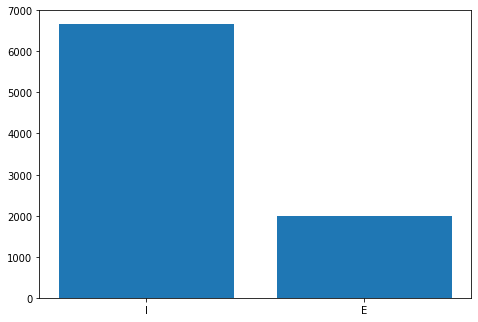

In [7]:
#After spliiting the personaliy type showing the data is still unbalanced for I/E and N/S
I, E = df_data_IE['is_E'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['I', 'E']
students = [I, E]
ax.bar(langs,students)
plt.show()

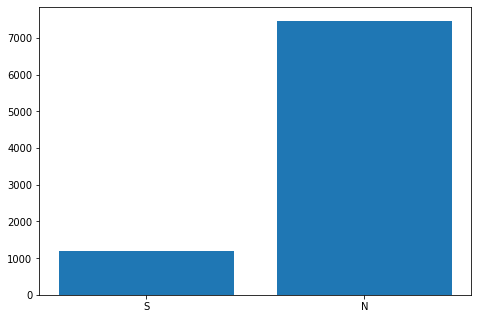

In [8]:
N, S = df_data_NS['is_S'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['S', 'N']
students = [S, N]
ax.bar(langs,students)
plt.show()

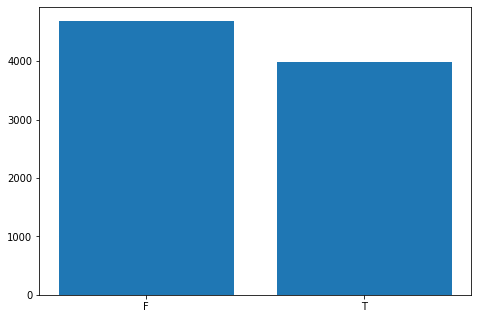

In [9]:
F, T = df_data_FT['is_T'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['F', 'T']
students = [F, T]
ax.bar(langs,students)
plt.show()

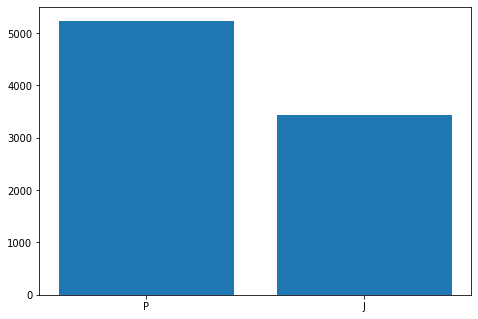

In [10]:
P, J = df_data_PJ['is_J'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['P', 'J']
students = [P, J]
ax.bar(langs,students)
plt.show()

In [11]:
#Separating into training, validation and Testing data 60, 20, 20 - 5205, 1735 and 1735
train_IE, validate_IE, test_IE = np.split(df_data_IE.sample(frac=1, random_state=42), [int(.6*len(df_data_IE)), int(.8*len(df_data_IE))])
train_NS, validate_NS, test_NS = np.split(df_data_NS.sample(frac=1, random_state=42), [int(.6*len(df_data_NS)), int(.8*len(df_data_NS))])
train_FT, validate_FT, test_FT = np.split(df_data_FT.sample(frac=1, random_state=42), [int(.6*len(df_data_FT)), int(.8*len(df_data_FT))])
train_PJ, validate_PJ, test_PJ = np.split(df_data_PJ.sample(frac=1, random_state=42), [int(.6*len(df_data_PJ)), int(.8*len(df_data_PJ))])

#validate_IE   # to see the df if correct data is transfered

#Transfering to dataframe
#train_IE = pd.DataFrame(train_IE)
#validate_IE = pd.DataFrame(validate_IE)
#test_IE = pd.DataFrame(test_IE)

In [12]:
#Split the data to X and Y i.e. posts and labels
#For IE labels
X_train_IE = pd.DataFrame(train_IE['posts'])
Y_train_IE = pd.DataFrame(train_IE['is_E'])
X_validate_IE = pd.DataFrame(validate_IE['posts'])
Y_validate_IE = pd.DataFrame(validate_IE['is_E'])
X_test_IE = pd.DataFrame(test_IE['posts'])
Y_test_IE = pd.DataFrame(test_IE['is_E'])

#For IE labels
X_train_NS = pd.DataFrame(train_NS['posts'])
Y_train_NS = pd.DataFrame(train_NS['is_S'])
X_validate_NS = pd.DataFrame(validate_NS['posts'])
Y_validate_NS = pd.DataFrame(validate_NS['is_S'])
X_test_NS = pd.DataFrame(test_NS['posts'])
Y_test_NS = pd.DataFrame(test_NS['is_S'])

#For IE labels
X_train_FT = pd.DataFrame(train_FT['posts'])
Y_train_FT = pd.DataFrame(train_FT['is_T'])
X_validate_FT = pd.DataFrame(validate_FT['posts'])
Y_validate_FT = pd.DataFrame(validate_FT['is_T'])
X_test_FT = pd.DataFrame(test_FT['posts'])
Y_test_FT = pd.DataFrame(test_FT['is_T'])

#For IE labels
X_train_PJ = pd.DataFrame(train_PJ['posts'])
Y_train_PJ = pd.DataFrame(train_PJ['is_J'])
X_validate_PJ = pd.DataFrame(validate_PJ['posts'])
Y_validate_PJ = pd.DataFrame(validate_PJ['is_J'])
X_test_PJ = pd.DataFrame(test_PJ['posts'])
Y_test_PJ = pd.DataFrame(test_PJ['is_J'])

#display(Y_train_IE.iloc[1])

In [13]:
#Cleaning the data Round 1
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers, remove URL, remove @, '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

X_train_IE_clean = pd.DataFrame(df_data.posts.apply(round1))
X_train_IE_clean

,posts
0,enfp and intj moments sportscenter no...
1,im finding the lack of me in these posts very ...
2,good one of course to which i say i kno...
3,dear intp i enjoyed our conversation the oth...
4,youre fired thats another silly misconceptio...
...,...
8670,ixfp just because i always think of cats as...
8671,soif this thread already exists someplace else...
8672,so many questions when i do these things i wo...
8673,i am very conflicted right now when it comes t...


In [14]:
# Tokenization - this is taken from SpaCy  

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
#stemmer = LancasterStemmer() # did not work

def tokenize(s):
    tokens = re_tok.sub(r' \1 ', s).split()
    return tokens

In [15]:
#Remove stopword and also added the MBTI types to it
stop = set(stopwords.words('english'))
stop.update(['infp','infj','intp','intj','entp','enfp','istp','isfp','entj','istj','enfj','isfj','estp','esfp','esfj','estj'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [16]:
#Fast Text embedding loading
from tqdm import tqdm

embeddings_index_glove = {}
f = open('C:/Sujata/CompScience/Winter 2021/Data Mining/Project Final/glove.6B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index_glove[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_glove))

400001it [00:31, 12852.05it/s]

Found 400001 word vectors.


In [17]:
def sent2vec(s, embeddings_index):
    words = str(s)
    words = tokenize(words)
    words = remove_stopwords(words)
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [18]:
gc.collect()

# Create sentence vectors using the above function for training and validation set - this will convert the full sentence 
#into a vector 

xtrain_IE_glove = [sent2vec(x, embeddings_index_glove) for x in X_train_IE['posts']]
xvalid_IE_glove = [sent2vec(x, embeddings_index_glove) for x in X_validate_IE['posts']]

xtrain_FT_glove = [sent2vec(x, embeddings_index_glove) for x in X_train_FT['posts']]
xvalid_FT_glove = [sent2vec(x, embeddings_index_glove) for x in X_validate_FT['posts']]

xtrain_IE_glove = np.array(xtrain_IE_glove)
xvalid_IE_glove = np.array(xvalid_IE_glove)

xtrain_FT_glove = np.array(xtrain_FT_glove)
xvalid_FT_glove = np.array(xvalid_FT_glove)

 
# Generate Word vectors of test data is_E
xtest_IE_glove = [sent2vec(x, embeddings_index_glove) for x in X_test_IE['posts']]
xtest_IE_glove = np.array(xtest_IE_glove)

# Generate Word vectors of test data is_T
xtest_FT_glove = [sent2vec(x, embeddings_index_glove) for x in X_test_FT['posts']]
xtest_FT_glove = np.array(xtest_FT_glove)

print("xtest_IE_glove.shape = ", xtest_IE_glove.shape)

xtest_IE_glove.shape =  (1735, 300)


In [19]:
# SVM Done for is_E class
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='log', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_glove, Y_train_IE[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_glove, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_glove, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E
CV score for class is_E is 0.7017507874880959
Validation score for class is_E is 0.45936599423631125


In [20]:
# SVM Done for is_T class
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='log', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_glove, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_glove, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_glove, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_T
CV score for class is_T is 0.8028738572597515
Validation score for class is_T is 0.7527377521613833


In [21]:
# is_E logistic regression
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_glove, Y_train_IE[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_glove, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_glove, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E
CV score for class is_E is 0.638931737078393
Validation score for class is_E is 0.5665706051873198


In [22]:
# is_T logistic regression
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_glove, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_glove, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_glove, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_T
CV score for class is_T is 0.7360366431002965
Validation score for class is_T is 0.6887608069164265


In [23]:
# is_E XGBoost

def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0  # look into it
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model

In [24]:
col = ['is_E']
preds = np.zeros((X_test_IE.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(xtrain_IE_glove, Y_train_IE[j], xvalid_IE_glove, Y_validate_IE[j])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_IE_glove), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_E
[0]	train-auc:0.70041	valid-auc:0.59799
[1]	train-auc:0.76345	valid-auc:0.60574
[2]	train-auc:0.79251	valid-auc:0.61057
[3]	train-auc:0.82519	valid-auc:0.61100
[4]	train-auc:0.84442	valid-auc:0.62633
[5]	train-auc:0.86481	valid-auc:0.62244
[6]	train-auc:0.87645	valid-auc:0.62155
[7]	train-auc:0.88631	valid-auc:0.62918
[8]	train-auc:0.89728	valid-auc:0.63294
[9]	train-auc:0.90327	valid-auc:0.63625
[10]	train-auc:0.90996	valid-auc:0.63960
[11]	train-auc:0.91566	valid-auc:0.63665
[12]	train-auc:0.92266	valid-auc:0.64757
[13]	train-auc:0.92689	valid-auc:0.64761
[14]	train-auc:0.93172	valid-auc:0.65044
[15]	train-auc:0.93775	valid-auc:0.65426
[16]	train-auc:0.94262	valid-auc:0.65616
[17]	train-auc:0.94670	valid-auc:0.65395
[18]	train-auc:0.95108	valid-auc:0.65282
[19]	train-auc:0.95466	valid-auc:0.65339
[20]	train-auc:0.95838	valid-auc:0.65304
[21]	train-auc:0.96199	valid-auc:0.65438
[22]	train-auc:0.96474	valid-auc:0.65579
[23]	train-auc:0.96750	valid-auc:0.65619
[24]	train-auc:0.

In [25]:
col = ['is_T']
preds = np.zeros((X_test_FT.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(xtrain_FT_glove, Y_train_FT[j], xvalid_FT_glove, Y_validate_FT[j])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_FT_glove), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_T
[0]	train-auc:0.78492	valid-auc:0.68535
[1]	train-auc:0.84667	valid-auc:0.72705
[2]	train-auc:0.87125	valid-auc:0.74504
[3]	train-auc:0.88599	valid-auc:0.76562
[4]	train-auc:0.89679	valid-auc:0.77315
[5]	train-auc:0.90409	valid-auc:0.77168
[6]	train-auc:0.91007	valid-auc:0.77527
[7]	train-auc:0.91690	valid-auc:0.77705
[8]	train-auc:0.92116	valid-auc:0.78081
[9]	train-auc:0.92608	valid-auc:0.78389
[10]	train-auc:0.93062	valid-auc:0.78592
[11]	train-auc:0.93517	valid-auc:0.78939
[12]	train-auc:0.93931	valid-auc:0.79144
[13]	train-auc:0.94279	valid-auc:0.79361
[14]	train-auc:0.94604	valid-auc:0.79468
[15]	train-auc:0.94874	valid-auc:0.79759
[16]	train-auc:0.95053	valid-auc:0.79940
[17]	train-auc:0.95451	valid-auc:0.80061
[18]	train-auc:0.95722	valid-auc:0.80321
[19]	train-auc:0.96059	valid-auc:0.80477
[20]	train-auc:0.96222	valid-auc:0.80460
[21]	train-auc:0.96465	valid-auc:0.80483
[22]	train-auc:0.96695	valid-auc:0.80652
[23]	train-auc:0.96902	valid-auc:0.80855
[24]	train-auc:0.